m

In [1]:
!pip install datasets -q
!pip install transformers -q
!pip install accelerate -U -q

In [2]:
import pandas as pd
import numpy as np
from datasets import load_dataset
from transformers import T5Tokenizer
from transformers import T5ForConditionalGeneration
from transformers import Trainer
from transformers import TrainingArguments
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import torch

# Data Analysis

In [3]:
dataset = load_dataset("OxAISH-AL-LLM/wiki_toxic")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
print(dataset)

# Print statistics of the dataset
print("Training set size:", dataset['train'].num_rows)
print("Validation set size:", dataset['validation'].num_rows)
print("Test set size:", dataset['test'].num_rows)

DatasetDict({
    train: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 127656
    })
    validation: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 31915
    })
    test: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 63978
    })
    balanced_train: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 25868
    })
})
Training set size: 127656
Validation set size: 31915
Test set size: 63978


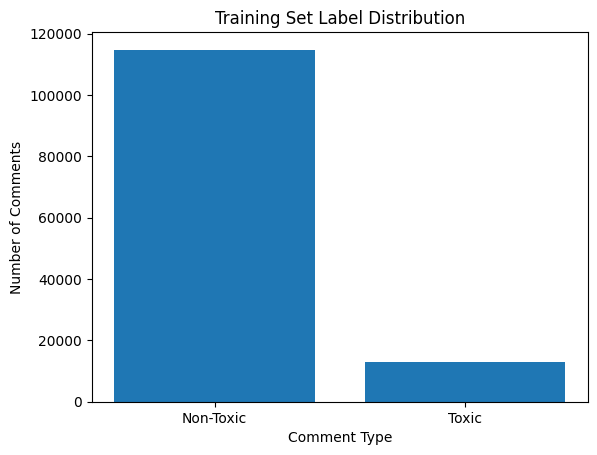

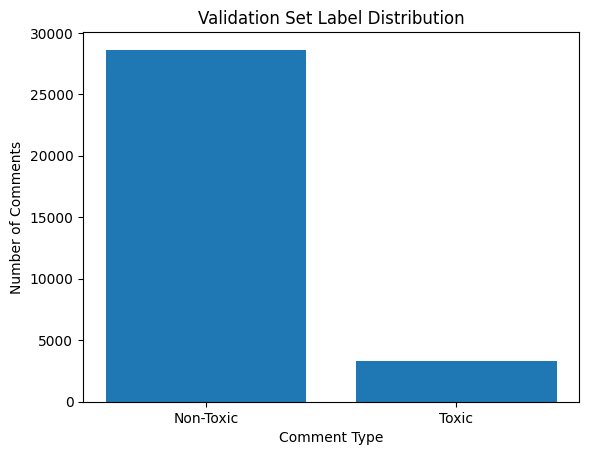

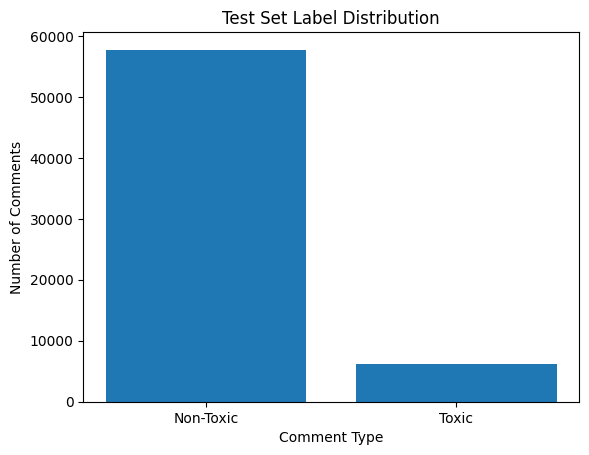

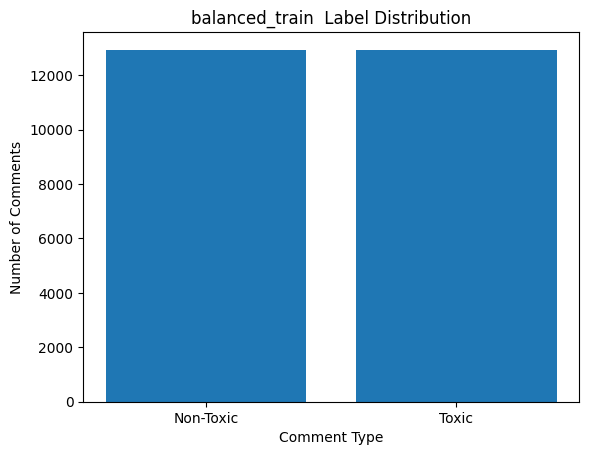

In [5]:
# Function to plot the label distribution
def plot_label_distribution(dataset, title):
    labels = dataset['label']
    unique, counts = np.unique(labels, return_counts=True)
    plt.bar(unique, counts, tick_label=["Non-Toxic", "Toxic"])
    plt.title(title)
    plt.xlabel('Comment Type')
    plt.ylabel('Number of Comments')
    plt.show()

# Plotting for train, validation, and test sets
plot_label_distribution(dataset['train'], 'Training Set Label Distribution')
plot_label_distribution(dataset['validation'], 'Validation Set Label Distribution')
plot_label_distribution(dataset['test'], 'Test Set Label Distribution')
plot_label_distribution(dataset['balanced_train'], 'balanced_train  Label Distribution')



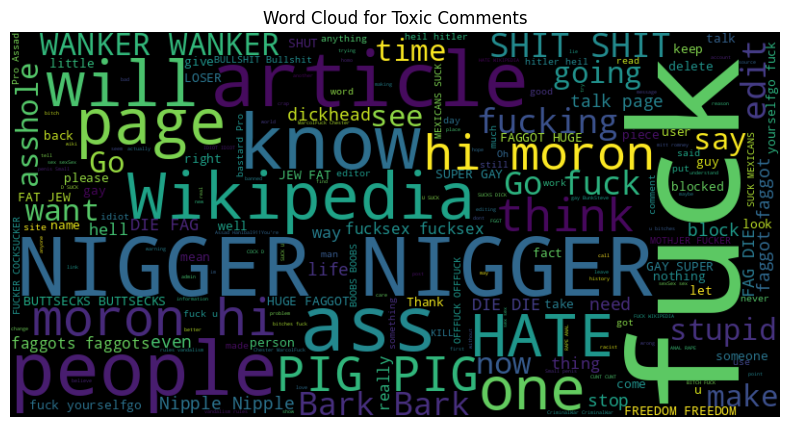

In [6]:
from wordcloud import WordCloud

# Function to generate word cloud
def generate_word_cloud(dataset, label, title):
    # Filter comments based on the label
    comments = dataset.filter(lambda example: example['label'] == label)['comment_text']
    text = " ".join(comment for comment in comments)
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# word cloud for toxic comments
generate_word_cloud(dataset['balanced_train'], 1, 'Word Cloud for Toxic Comments')

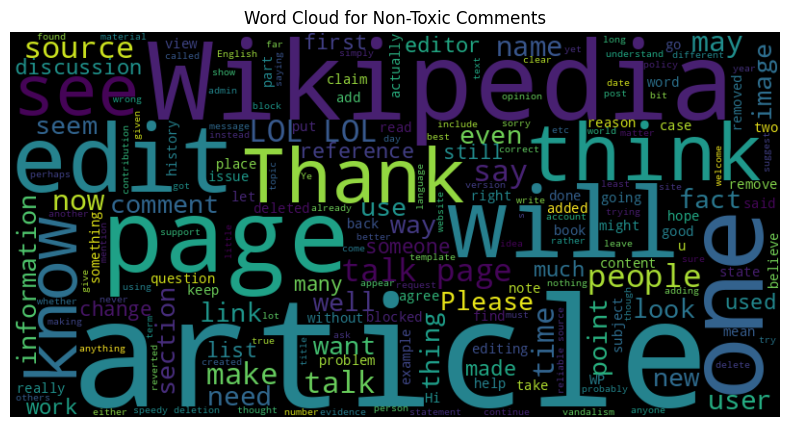

In [7]:
# word cloud for non-toxic comments
generate_word_cloud(dataset['balanced_train'], 0, 'Word Cloud for Non-Toxic Comments')

# Data Preparation

In [8]:
# Deleting Train data as it is not balanced
del dataset['train']
print(dataset)

DatasetDict({
    validation: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 31915
    })
    test: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 63978
    })
    balanced_train: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 25868
    })
})


In [9]:
dataset["balanced_train"] = dataset["balanced_train"].shuffle(42).select(range(5000))
dataset["validation"] = dataset["validation"].shuffle(42).select(range(2000))
dataset["test"] = dataset["test"].shuffle(42).select(range(2000))

In [10]:
dataset

DatasetDict({
    validation: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 2000
    })
    balanced_train: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 5000
    })
})

In [11]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW

# Load the tokenizer and the model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Prepare the datasets
class ToxicCommentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ToxicCommentDataset(dataset['balanced_train']['comment_text'], dataset['balanced_train']['label'], tokenizer)
val_dataset = ToxicCommentDataset(dataset['validation']['comment_text'], dataset['validation']['label'], tokenizer)

# Initialize the DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
del train_dataset
del val_dataset

# Model Training

In [13]:
# Setting the device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-6)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:
# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch: {epoch+1}, Loss: {total_loss/len(train_loader)}')

Epoch: 1, Loss: 0.3663020611237794
Epoch: 2, Loss: 0.15494042051771578
Epoch: 3, Loss: 0.10238915862598882


# Model Evaluation

In [15]:
from sklearn.metrics import classification_report

# Function to get predictions
def get_predictions(model, data_loader):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in data_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())
    return predictions, true_labels

# Get predictions and true labels
predictions, true_labels = get_predictions(model, val_loader)

# Evaluation metrics
print(classification_report(true_labels, predictions, target_names=['Non-Toxic', 'Toxic']))

              precision    recall  f1-score   support

   Non-Toxic       1.00      0.92      0.95      1792
       Toxic       0.57      0.96      0.71       208

    accuracy                           0.92      2000
   macro avg       0.78      0.94      0.83      2000
weighted avg       0.95      0.92      0.93      2000



Accuracy :  0.92
--------------------------------------------------
F1 :  [0.95348837 0.71428571]
--------------------------------------------------
Reacll :  [0.91517857 0.96153846]
--------------------------------------------------
Precision :  [0.99514563 0.56818182]
--------------------------------------------------
Confusion Matrix....
 [[1640  152]
 [   8  200]]
--------------------------------------------------
Classification Report....
               precision    recall  f1-score   support

           0       1.00      0.92      0.95      1792
           1       0.57      0.96      0.71       208

    accuracy                           0.92      2000
   macro avg       0.78      0.94      0.83      2000
weighted avg       0.95      0.92      0.93      2000

--------------------------------------------------
Plotting Confusion Matrix...



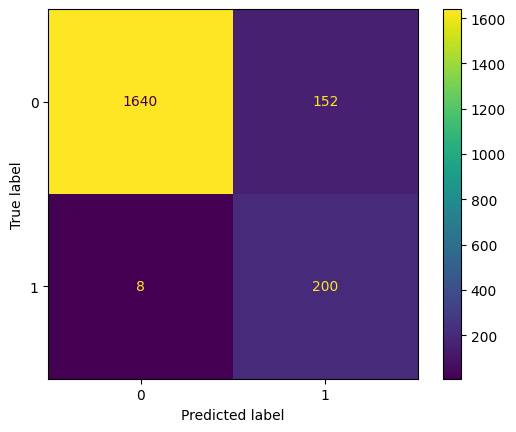

In [19]:
# Importing Evaluation matrces
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

y_test = true_labels
y_pred = predictions


# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Precision
precision = precision_score(y_test, y_pred, average=None)

# Recall
recall = recall_score(y_test, y_pred, average=None)

# F1 Score
f1_sco = f1_score(y_test, y_pred, average=None)

# Confusion Matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Report
report = classification_report(y_test, y_pred)

print('Accuracy : ', accuracy)
print("-"*50)
print('F1 : ', f1_sco)
print("-"*50)
print('Reacll : ', recall)
print("-"*50)
print('Precision : ', precision)
print("-"*50)
print('Confusion Matrix....\n', confusion_mat)
print("-"*50)
print('Classification Report....\n', report)
print("-"*50)
print('Plotting Confusion Matrix...\n')
disp = ConfusionMatrixDisplay(confusion_mat, display_labels=None)
disp.plot()
plt.show()